In [1]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade transformers
!pip install -q datasets
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 55.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00


In [3]:
# Import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from datasets import Dataset

from datasets import Dataset

import transformers
from transformers import AutoTokenizer
from transformers import DefaultDataCollator
from transformers import TFAutoModelForSequenceClassification

import tensorflow
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import SparseCategoricalCrossentropy

print(transformers.__version__)
print(tensorflow.__version__)


4.39.3
2.15.0


# Import the dataset

In [4]:
# Read the dataset
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cs587/assignment4/spam.csv', index_col=False)

# Display the shape of the dataset
print('Data shape', dataset.shape)

# Display the first 10 messages in the dataset
dataset.head(10)

Data shape (5572, 2)


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [5]:
# Display fully the first few messages (can you guess which one is spam without looking at the label?)
print(dataset.iloc[0,1])
print(dataset.iloc[1,1])
print(dataset.iloc[2,1])
print(dataset.iloc[3,1])
print(dataset.iloc[5,1])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv


In [6]:
# Check the counts per each category
dataset['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

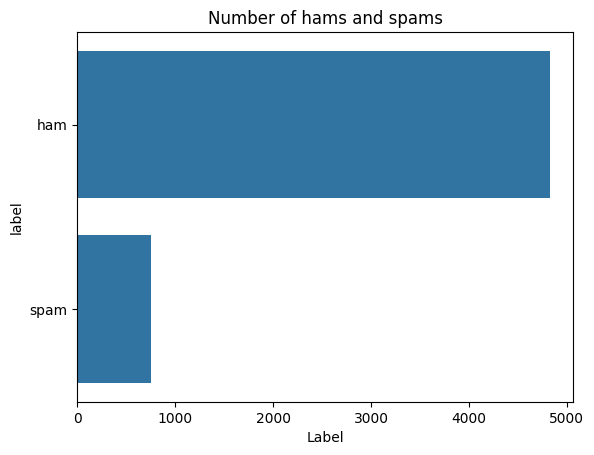

In [7]:
# Plot the distribution of ham and spam messages
sns.countplot(dataset['label'])
plt.xlabel("Label")
plt.title('Number of hams and spams')
plt.show()

In [8]:
# covert the labels to have numerical 0 and 1 values
dataset['label'] = pd.Categorical(dataset['label']).codes

dataset.head(10)

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


# Create train, test, and validation datasets

In [9]:
# split the dataset into train, test, and validation sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# create the datasets from pandas dataframes
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# remove the index column to retain only label and text columns
train_dataset = train_dataset.remove_columns(["__index_level_0__"])
val_dataset  = val_dataset .remove_columns(["__index_level_0__"])
test_dataset = test_dataset.remove_columns(["__index_level_0__"])

# display the length of the train data, validation data and test data
print(f'train data length: {len(train_dataset)}')
print(f'validation data length: {len(val_dataset)}')
print(f'test data length: {len(test_dataset)}')

train data length: 4011
validation data length: 446
test data length: 1115


# Import the tokenizer for a pretrained "distilbert-base-uncased"

In [10]:
# define the tokenizer for the model
model_for_tkn = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_for_tkn)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [11]:
# define the tokenize function
def tokenize(rows):
    return tokenizer(rows['text'], padding="max_length", truncation=True)

# set dataset formate
train_dataset.set_format(type=None)
val_dataset.set_format(type=None)
test_dataset.set_format(type=None)

# tokenize the dataset
train_ds_tkd = train_dataset.map(tokenize, batched=True)
test_ds_tkd = test_dataset.map(tokenize, batched=True)
val_ds_tkd = val_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/4011 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

Map:   0%|          | 0/446 [00:00<?, ? examples/s]

# Convert the train, test, and validation datasets into TensorFlow tensors using data collator

In [12]:
# define data collator
data_collator = DefaultDataCollator(return_tensors="tf")


train_ds_tf = train_ds_tkd.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8)

val_ds_tf = val_ds_tkd.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8)

test_ds_tf = test_ds_tkd.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:401: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


# Import the pretrained model "distilbert-base-uncased"

In [13]:
# define the model
model_bt_bs = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

# Compile and fit the model on the training dataset and use the validation dataset for validation during training

In [14]:
# compile the model
model_bt_bs.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [15]:
# train the model
history = model_bt_bs.fit(train_ds_tf, validation_data=val_ds_tf, epochs=3)

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
502/502 [==============================] - 299s 478ms/step - loss: 0.0715 - accuracy: 0.9758 - val_loss: 0.0429 - val_accuracy: 0.9888
Epoch 2/3
502/502 [==============================] - 242s 481ms/step - loss: 0.0236 - accuracy: 0.9945 - val_loss: 0.0463 - val_accuracy: 0.9933
Epoch 3/3
502/502 [==============================] - 240s 479ms/step - loss: 0.0120 - accuracy: 0.9970 - val_loss: 0.0880 - val_accuracy: 0.9843


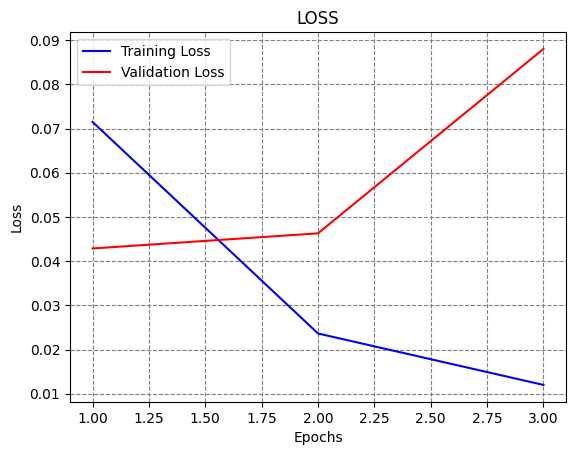

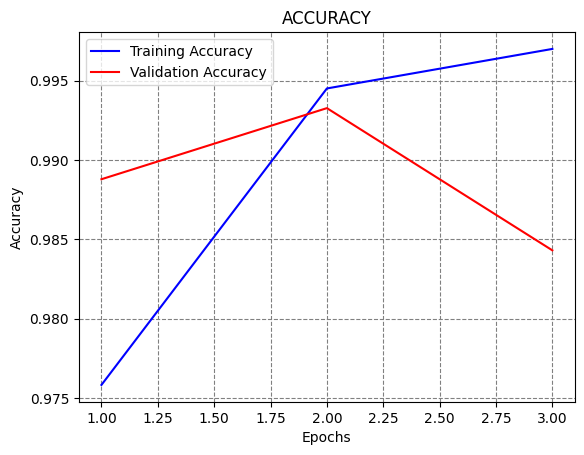

In [16]:
# Plot the loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Evaluate the model on test dataset

In [24]:
# Evaluate the Model on Test Data

acc = model_bt_bs.evaluate(test_ds_tf)
print("Classification Accuracy: {}".format(round(acc[1],4)))

140/140 [==============================] - 22s 156ms/step - loss: 0.0273 - accuracy: 0.9946
Classification Accuracy: 0.9946
